In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
%matplotlib inline

In [7]:
from empiricaldist import Pmf

In [3]:
def pmf_from_dist(dist, low, high):
    """Make a discrete approximation of a continuous distribution.
    
    dist: SciPy dist object
    low: low end of range
    high: high end of range
    
    returns: normalized Pmf
    """
    qs = np.linspace(low, high, 101)
    ps = dist.pdf(qs)
    pmf = Pmf(ps, qs)
    pmf.normalize()
    return pmf

def make_uniform(qs, name=None, **options):
    """Make a Pmf that represents a uniform distribution."""
    pmf = Pmf(1.0, qs, **options)
    pmf.normalize()
    if name:
        pmf.index.name = name
    return pmf

In [4]:
# Revisiting the World Cup problem
# We used a gamma to represent the prior, and a Poisson to compute prob(goals scored)

from scipy.stats import gamma

In [8]:
alpha = 1.4
dist = gamma(alpha)

# And here we use grid approximation, which should be familiar

lams = np.linspace(0, 10, 101)
prior = pmf_from_dist(dist, lams[0], lams[-1])

In [9]:
from scipy.stats import poisson

In [10]:
k = 4
likelihood = poisson(lams).pmf(k)

# the update

posterior = prior * likelihood
posterior.normalize()

np.float64(0.05015532557804499)

In [11]:
# Now to solve the same problem with a conjugate prior

# An excellent reason to choose a gamma distribution for the prior in the WC problem is that it's a
# conjugate prior to a Poisson distribution

# To demonstrate, we switch to the 2-parameter version of the gamma distribution

def make_gamma_dist(alpha, beta):
    """Makes a gamma object"""
    dist = gamma(alpha, scale=1/beta)
    dist.alpha = alpha
    dist.beta = beta
    return dist

In [12]:
# Here's the prior with alpha=1.4 and beta=1

alpha = 1.4
beta = 1

prior_gamma = make_gamma_dist(alpha, beta)
prior_gamma.mean()

np.float64(1.4)

In [13]:
# As we'll see, we can do a Bayesian update with k goals just by making a gamma with alpha+k and beta+1

def update_gamma(prior, data):
    """Update a gamma prior"""
    k, t = data
    alpha = prior.alpha + k
    beta = prior.beta + t
    return make_gamma_dist(alpha, beta)

In [14]:
data = 4, 1
posterior_gamma = update_gamma(prior_gamma, data)

In [15]:
# We can confirm that the update really is this simple

posterior_conjugate = pmf_from_dist(posterior_gamma, lams[0], lams[-1])

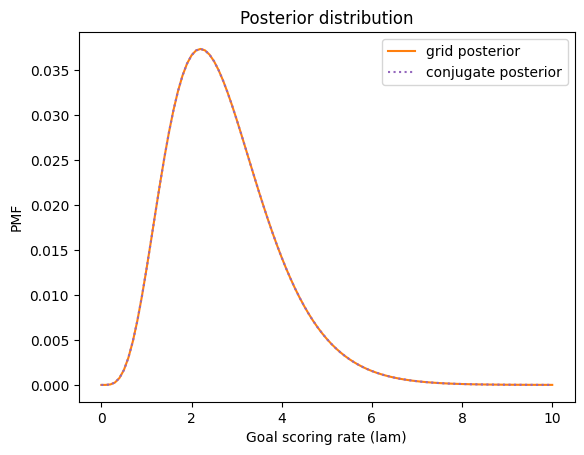

In [16]:
posterior.plot(label='grid posterior', color='C1', title='Posterior distribution', xlabel='Goal scoring rate (lam)', ylabel='PMF')
posterior_conjugate.plot(label='conjugate posterior', color='C4', ls=':')
plt.legend()

In [17]:
np.allclose(posterior, posterior_conjugate) # So these are basically the same

True

In [18]:
# This works because the update multiplies a gamma PDF and a Poisson PMF to produce a gamma distribution

In [19]:
# Another look at the Euro problem.
# When we solved it, we started with a uniform prior, then used the binomial to compute the likelihood

xs = np.linspace(0, 1, 101)
uniform = make_uniform(xs, 'uniform')

from scipy.stats import binom

k, n = 140, 250
xs = uniform.qs
likelihood = binom.pmf(k, n, xs)

posterior = uniform * likelihood
posterior.normalize()

np.float64(0.003944617569326651)

In [20]:
# This can be done more efficiently using the beta distribution, the binomial's conjugate prior

import scipy.stats

def make_beta(alpha, beta):
    """Makes a beta object"""
    dist = scipy.stats.beta(alpha, beta)
    dist.alpha = alpha
    dist.beta = beta
    return dist

In [21]:
# As it turns out, the uniform distribution is a beta with alpha = beta = 1

alpha = 1
beta = 1

prior_beta = make_beta(alpha, beta)

In [22]:
# When we multiply the beta PDF and the binomial PMF, we get a binomial with parameters alpha + k and beta + n - k

def update_beta(prior, data):
    """Updates a beta distribution"""
    k, n = data
    alpha = prior.alpha + k
    beta = prior.beta + n - k
    return make_beta(alpha, beta)

In [23]:
# So the update works easily

data = 140, 250
posterior_beta = update_beta(prior_beta, data)

posterior_conjugate = pmf_from_dist(posterior_beta, xs[0], xs[-1])

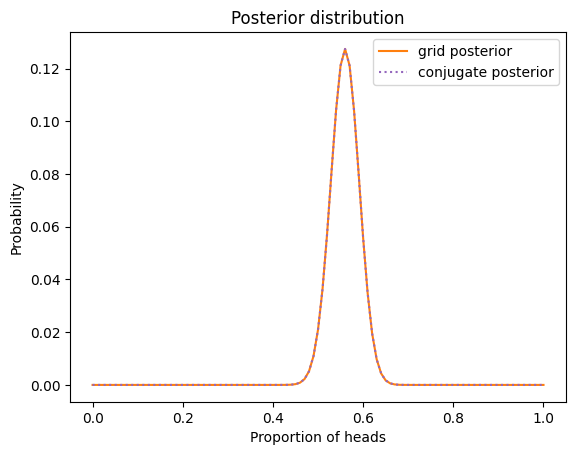

In [24]:
posterior.plot(label='grid posterior', color='C1', title='Posterior distribution', xlabel='Proportion of heads', ylabel='Probability')
posterior_conjugate.plot(label='conjugate posterior', color='C4', ls=':')
plt.legend()

In [25]:
np.allclose(posterior, posterior_conjugate) # Again, basically the same

True

In [26]:
# Animal preserve problem: the only animals are lions, tigers, and bears, but we don't know how many there are
# In a tour we see 3 lions, 2 tigers, 1 bear
# We use the data to estimate the % belonging to each species. Prevalences mean we can use the multinomial dist to calculate probabilities

# Suppose we know the %s of lions, tigers, and bears are 0.4, 0.3, and 0.3

from scipy.stats import multinomial

data = 3, 2, 1
n = np.sum(data)
ps = 0.4, 0.3, 0.3

multinomial.pmf(data, n, ps)

np.float64(0.10368)

In [27]:
# Fortunately the multinomial has a conjugate prior, the Dirichlet

from scipy.stats import dirichlet

In [28]:
alpha = 1, 2, 3
dist = dirichlet(alpha) # in a Dirichlet, the parameter alpha is a vector

In [29]:
dist.rvs()

array([[0.03359352, 0.27613953, 0.69026695]])

In [30]:
dist.rvs().sum()

np.float64(1.0)

In [31]:
# We can explore what these values look like by random sampling

sample = dist.rvs(1000)
sample.shape

(1000, 3)

In [32]:
from empiricaldist import Cdf

cdfs = [Cdf.from_seq(col) for col in sample.transpose()]

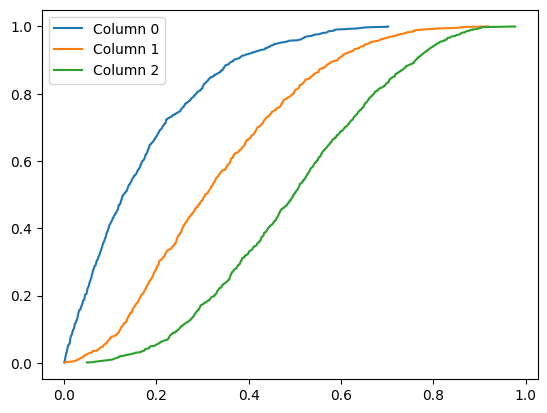

In [33]:
for i, cdf in enumerate(cdfs):
    label = f"Column {i}"
    cdf.plot(label=label)
    
plt.legend()

In [34]:
# The marginal distributions of each dirichlet parameter are beta-distributed

def marginal_beta(alpha, i):
    """Compute the ith marginal of a Dirichlet distribution"""
    total = np.sum(alpha)
    return make_beta(alpha[i], total-alpha[i])

In [35]:
# We can use this to compute marginal distributions for the 3 variables

marginals = [marginal_beta(alpha, i) for i in range(len(alpha))]

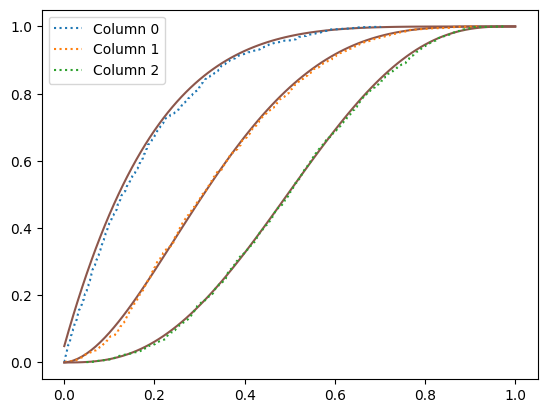

In [36]:
# We can then plot CDFs of these distributions and compare to the CDFs of the samples

xs = np.linspace(0, 1, 101)

for i in range(len(alpha)):
    label = f'Column {i}'
    
    pmf = pmf_from_dist(marginals[i], xs[0], xs[-1])
    pmf.make_cdf().plot(color='C5')
    
    cdf = cdfs[i]
    cdf.plot(label=label, ls=':')
    
plt.legend()

In [37]:
# Close enough to confirm that the marginals of the Dirichlet are beta-distributed

# Exercise 18-1: Revisiting the World Cup semifinal analysis
# PDF of the gamma prior * PDF of exponential likelihood:
# ((lam^(alpha-1))*e^(-(lam)*(beta))) * ((lam) * e^(-(lam)*t))) = lam^(alpha)*e^(-(lam)*(beta+t))
# This is a gamma distribution with parameters (alpha+1) and (beta+t)

# We can update with the same update function

data = 1, 11/90
posterior1 = update_gamma(prior_gamma, data)

data2 = 1, 12/90
posterior2 = update_gamma(posterior1, data2)

print(prior_gamma.mean(), posterior1.mean(), posterior2.mean())

1.4 2.1386138613861387 2.7079646017699113


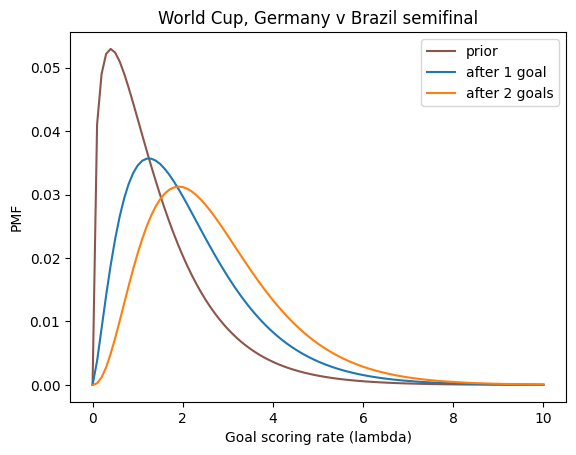

In [38]:
pmf_from_dist(prior_gamma, lams[0], lams[-1]).plot(label='prior', color='C5', ylabel='PMF')
pmf_from_dist(posterior1, lams[0], lams[-1]).plot(label='after 1 goal', xlabel='Goal scoring rate (lambda)')
pmf_from_dist(posterior2, lams[0], lams[-1]).plot(label='after 2 goals', title='World Cup, Germany v Brazil semifinal')
plt.legend()

In [39]:
# Ex 18-2: using the triangle prior to update the euro problem
# Can we find a beta distribution that closely approximates the triangle

# Here's the triangle prior again

ramp_up = np.arange(50)
ramp_down = np.arange(50, -1, -1)

a = np.append(ramp_up, ramp_down)
xs = uniform.qs

triangle = Pmf(a, xs, name='triangle')
triangle.normalize()

# and how we updated it before

k, n = 140, 250
likelihood = binom.pmf(k, n, xs)

posterior = triangle * likelihood
posterior.normalize()

np.float64(0.007008842590059087)

In [40]:
# Here's the beta used as a uniform prior

alpha = 1
beta = 1

prior_beta = make_beta(alpha, beta)
prior_beta.mean()

np.float64(0.5)

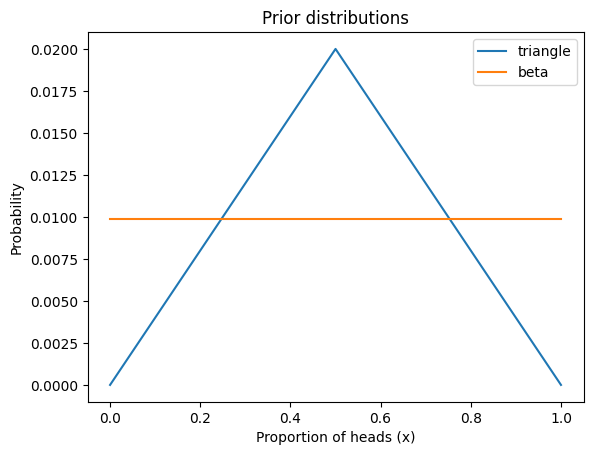

In [41]:
prior_pmf = pmf_from_dist(prior_beta, xs[0], xs[-1])

triangle.plot(label='triangle', xlabel='Proportion of heads (x)', ylabel='Probability')
prior_pmf.plot(label='beta', title='Prior distributions')
plt.legend()

In [42]:
# Solution recommends estimating the posterior using the conjugate prior, and then comparing the posteriors as before

data = 140, 250
posterior_beta = update_beta(prior_beta, data)
posterior_beta.mean()

np.float64(0.5595238095238095)

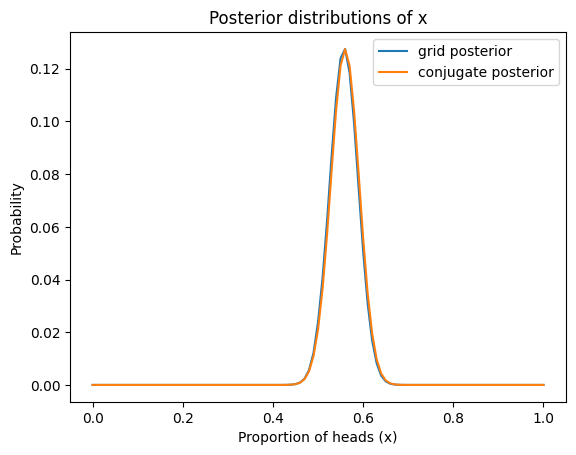

In [44]:
posterior_conjugate = pmf_from_dist(posterior_beta, xs[0], xs[-1])

posterior.plot(label='grid posterior', xlabel='Proportion of heads (x)', ylabel='Probability')
posterior_conjugate.plot(label='conjugate posterior', title='Posterior distributions of x')
plt.legend()

In [45]:
np.allclose(posterior, posterior_conjugate) # So not identical, but very close

False

In [46]:
# Ex 18-3: Suppose an online product has 3 sellers:
# 1 has 10 reviews that are 100% positive, 1 has 50 reviews that are 96% positive, 1 has 200 reviews that are 93% positive

# Suppose each seller has a prob x of giving good service and getting a positive review
# We want to choose the seller with the highest value of x

# Suggested prior is a beta with alpha=8 and beta=2

alpha = 8
beta = 2

prior_beta = make_beta(alpha, beta)

<Axes: xlabel='Probability of positive rating', ylabel='PDF'>

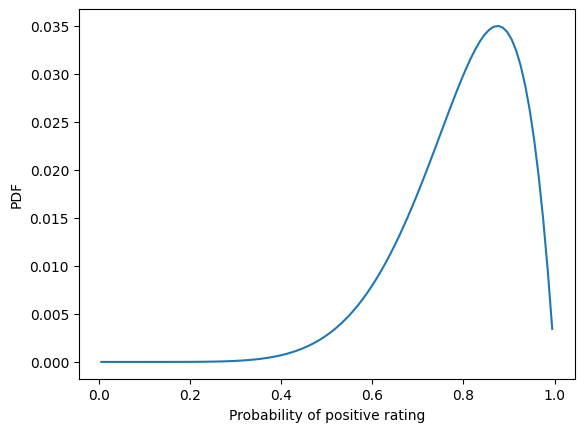

In [48]:
xs = np.linspace(0.005, 0.995, 199) # The solution recommends a prior not including 0 and 1
prior_pmf = pmf_from_dist(prior_beta, xs[0], xs[-1])

prior_pmf.plot(xlabel='Probability of positive rating', ylabel='PDF')

In [49]:
# The update uses update_beta, and the data consists of pairs of positive ratings and total ratings

data1 = 10, 10
data2 = 48, 50
data3 = 186, 200

seller1 = update_beta(prior_beta, data1)
seller2 = update_beta(prior_beta, data2)
seller3 = update_beta(prior_beta, data3)

seller1_pmf = pmf_from_dist(seller1, xs[0], xs[-1])
seller2_pmf = pmf_from_dist(seller2, xs[0], xs[-1])
seller3_pmf = pmf_from_dist(seller3, xs[0], xs[-1])

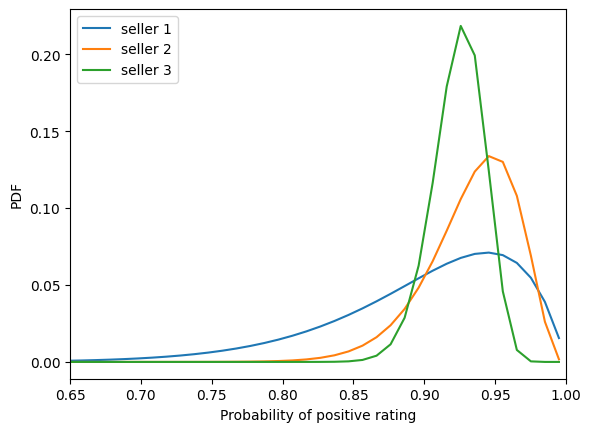

In [52]:
seller1_pmf.plot(label='seller 1', xlabel='Probability of positive rating')
seller2_pmf.plot(label='seller 2', ylabel='PDF')
seller3_pmf.plot(label='seller 3')
plt.xlim(0.65, 1.0)
plt.legend()

In [51]:
seller1.mean(), seller2.mean(), seller3.mean()

(np.float64(0.9),
 np.float64(0.9333333333333333),
 np.float64(0.9238095238095239))

In [53]:
# Some additional steps are presented in the solution without explanation
# How confident should we be that the seller with the highest posterior mean has the highest value of x?

iters = 10000
a = np.empty((3, iters))

a[0] = seller1.rvs(iters)
a[1] = seller2.rvs(iters)
a[2] = seller3.rvs(iters)

best = np.argmax(a, axis=0)
Pmf.from_seq(best)

,probs
0,0.2985
1,0.4711
2,0.2304


<Axes: xlabel='Probability of positive rating', ylabel='PDF'>

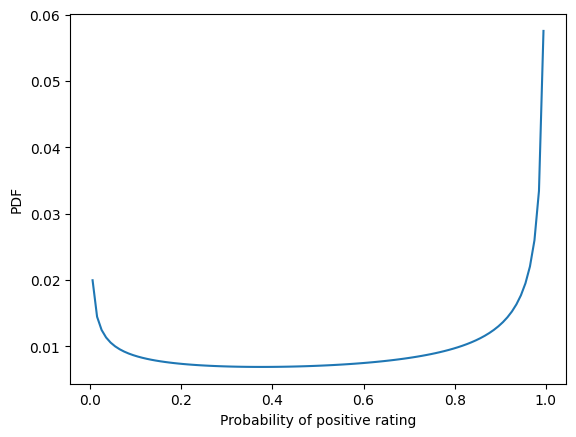

In [54]:
# Try a prior with alpha=0.7 and beta=0.5

alpha = 0.7
beta = 0.5

prior_beta2 = make_beta(alpha, beta)

xs = np.linspace(0.005, 0.995, 199)
prior_pmf2 = pmf_from_dist(prior_beta2, xs[0], xs[-1])

prior_pmf2.plot(xlabel='Probability of positive rating', ylabel='PDF')

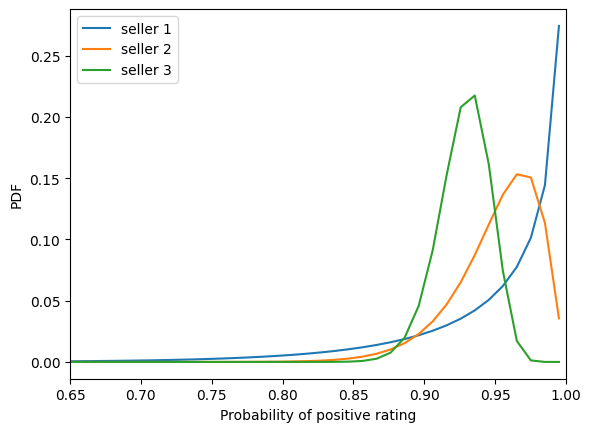

In [55]:
seller1 = update_beta(prior_beta2, data1)
seller2 = update_beta(prior_beta2, data2)
seller3 = update_beta(prior_beta2, data3)

seller1_pmf = pmf_from_dist(seller1, xs[0], xs[-1])
seller2_pmf = pmf_from_dist(seller2, xs[0], xs[-1])
seller3_pmf = pmf_from_dist(seller3, xs[0], xs[-1])

seller1_pmf.plot(label='seller 1', xlabel='Probability of positive rating')
seller2_pmf.plot(label='seller 2', ylabel='PDF')
seller3_pmf.plot(label='seller 3')
plt.xlim(0.65, 1.0)
plt.legend()

In [56]:
seller1.mean(), seller2.mean(), seller3.mean()

(np.float64(0.9553571428571429),
 np.float64(0.951171875),
 np.float64(0.9279324055666004))

In [57]:
iters = 10000
a = np.empty((3, iters))

a[0] = seller1.rvs(iters)
a[1] = seller2.rvs(iters)
a[2] = seller3.rvs(iters)

best = np.argmax(a, axis=0)
Pmf.from_seq(best)

,probs
0,0.6352
1,0.3112
2,0.0536


In [58]:
# Ex 18-4: Use a dirichlet prior with alpha=[1, 1, 1] to solve the animal preserve problem

alpha = np.array([1, 1, 1])
# prior = dirichlet(alpha) the solution doesn't call for this

data = 3, 2, 1

posterior_alpha = alpha + data

In [59]:
marginal_lion = marginal_beta(posterior_alpha, 0)
marginal_tiger = marginal_beta(posterior_alpha, 1)
marginal_bear = marginal_beta(posterior_alpha, 2)

marginal_lion.mean(), marginal_tiger.mean(), marginal_bear.mean()

(np.float64(0.4444444444444444),
 np.float64(0.3333333333333333),
 np.float64(0.2222222222222222))

In [60]:
# This is basically it. The solution calls for using the dirichlet to construct the summary measures

dist = dirichlet(posterior_alpha)
index = ['lion', 'tiger', 'bear']
pd.DataFrame(dist.mean(), index, columns=['prob'])

,prob
lion,0.444444
tiger,0.333333
bear,0.222222
